# OASIS Brain Stylegan

## Import Packages

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
# tf_device='/gpu:0'
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))


import matplotlib.pyplot as plt
import pandas as pd
from random import random, randint
from tensorflow.keras import layers
from tensorflow.keras import backend as k
from IPython import display


print("Import Complete")

2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Import Complete


## Set up constant variables

In [2]:
BATCH_SIZE = 128
EPOCHS = 30
IMAGE_SIZE = (64, 64)
h, w = IMAGE_SIZE

## Load Data

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.getcwd()+'\\keras_png_slices_data\\keras_png_slices_train',
    label_mode=None,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(h, w),
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.getcwd()+'\\keras_png_slices_data\\keras_png_slices_test',
    label_mode=None,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(h, w),
    shuffle=True
)

validate_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.getcwd()+'\\keras_png_slices_data\\keras_png_slices_validate',
    label_mode=None,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    image_size=(h, w),
    shuffle=True
)

Found 9664 files belonging to 1 classes.
Found 544 files belonging to 1 classes.
Found 1120 files belonging to 1 classes.


## Preprocess Images
### Normalization

In [4]:
def preprocess_image(image):
    image = tf.cast(image/255., tf.float32)
    return image

train_ds = train_ds.map(preprocess_image).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).cache()
test_ds = test_ds.map(preprocess_image).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).cache()
validate_ds = validate_ds.map(preprocess_image).prefetch(buffer_size=tf.data.experimental.AUTOTUNE).cache()


## Preview Data

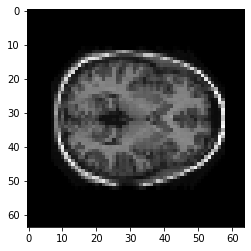

Shape: (64, 64, 1)
Data Type: <dtype: 'float32'>
Min tf.Tensor(0.0, shape=(), dtype=float32)
Max tf.Tensor(0.9107843, shape=(), dtype=float32)


In [5]:
imageNum = randint(0, 127)
previewImage = list(train_ds.take(1))[0][imageNum]
plt.imshow(previewImage, cmap='gray')
plt.show()

print("Shape:", previewImage.shape)
print("Data Type:", previewImage.dtype)
print("Min", tf.math.reduce_min(previewImage))
print("Max", tf.math.reduce_max(previewImage))

## Initialize Models

In [10]:
def make_generator_model():
    latent_input0 = layers.Input(shape=(100,))

    # Mapping Network
    mnfc = layers.Dense(512, activation="relu")(latent_input0)
    for i in range(7):
        mnfc = layers.Dense(512, activation="relu")(mnfc)

    # Noises
    noise_input0 = layers.Input(shape=(4, 4, 1))
    n1 = layers.Dense(512, activation="relu")(noise_input0)

    # synthesis Network
    l1_1 = layers.Dense(4*4*512, activation="relu")(latent_input0)
    l1_2 = layers.Reshape((4, 4, 512))(l1_1)
    l1_3 = layers.Add()([l1_2, n1])
    # AdaIN
    def AdaIN(x, y):
        x_mean, x_std = k.mean(x), k.std(x)
        y_mean, y_std = k.mean(y), k.std(y)
        return tf.multiply(y_std, tf.divide(x - x_mean, x_std)) + y_mean
    l1_4 = AdaIN(l1_3, mnfc)
    l1_5 = layers.Conv2D(512, (3, 3), (2, 2))(l1_4)
    l1_6 = layers.Add()([l1_5, n1])
    l1_7 = AdaIN(l1_6, mnfc)

    model = tf.keras.Model(inputs=[latent_input0, noise_input0], outputs=[l1_7])
    return model

model = make_generator_model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 512)          51712       input_9[0][0]                    
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 512)          262656      dense_40[0][0]                   
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 512)          262656      dense_41[0][0]                   
____________________________________________________________________________________________

In [7]:
def make_discriminator_model():
    model = tf.keras.models.Sequential()

    model.add(layers.Conv2D(IMAGE_SIZE, (5, 5), strides=(2, 2), padding='same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(IMAGE_SIZE * 2, (5, 5), strides=(2, 2), padding='same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(IMAGE_SIZE * 4, (5, 5), strides=(2, 2), padding='same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(IMAGE_SIZE * 8, (5, 5), strides=(2, 2), padding='same', input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

## Define Losses

In [36]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    realLoss = cross_entropy(tf.ones_like(real_output), real_output)
    fakeLoss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return realLoss + fakeLoss

def generator_loss(fakeOutput):
    return cross_entropy(tf.ones_like(fakeOutput), fakeOutput)

## Define Optimizers

In [37]:
generatorOptimizer = tf.keras.optimizers.Adam(1e-4)
discriminatorOptimizer = tf.keras.optimizers.Adam(1e-4)

## Define Training Steps

In [ ]:
def train_step(images):
    pass

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 4), constrained_layout=True)

    for i in range(predictions.shape[0]):
        plt.subplot(2, 4, i + 1)
        plt.imshow((predictions[i].numpy() * 127.5 + 127.5).astype("uint8"))
        plt.axis("off")

    plt.savefig("./betterimg/image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

In [ ]:
def train(train, test, validate, epochs):
    pass

## Train Model

## Evaluate model